# Hávamál analysis

Second Edda's poem: *sayings of the High One* or Hávamál. What is different from the Völuspá?

## Contents

* Download used corpora
* Read them
* Retrieve the original structure
* Syllabification
* Transcribe phonetically the text
* Alliteration
* Vocabulary
* Frequency
* Poetry


### All imports

In [1]:
import os
module_path = os.path.join(os.environ["HOME"], "cltk_data/old_norse/text/old_norse_texts_heimskringla/")
import re
import sys
sys.path.append(module_path)
from collections import Counter

from cltk.corpus.utils.importer import CorpusImporter
from cltk.corpus.old_norse.syllabifier import hierarchy
hierarchy[5].append("z")
hierarchy[5].append("x")
from cltk.phonology.syllabify import Syllabifier
from cltk.phonology import utils as phu
from cltk.phonology.old_norse import transcription as ont 
from cltk.utils.frequency import Frequency
from cltk.tag.pos import POSTag
from cltk.prosody.old_norse.verse import MetreManager, Fornyrdhislag, Ljoodhhaattr, ShortLine, LongLine

from old_norse.text.old_norse_texts_heimskringla import text_manager
from old_norse.text.old_norse_texts_heimskringla import reader as heim_reader
#from syllabified_text_reader import read_annotated_text

from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

### Download Old Norse Corpora to cltk_data directory

In [2]:
onc = CorpusImporter("old_norse")
onc.import_corpus("old_norse_texts_heimskringla")
onc.import_corpus('old_norse_models_cltk')
heim_reader.__file__

'/home/pi/cltk_data/old_norse/text/old_norse_texts_heimskringla/reader.py'

Configure **ipython**.

```bash
$ ipython profile create
$ ipython locate
$ nano .ipython/profile_default/ipython_config.py
```
 Add it a the end of the file:
```bash
c.InteractiveShellApp.exec_lines = [
    'import sys; import os; sys.path.append(os.path.join(os.environ["HOME"], "cltk_data"))',
    'import sys; import os; sys.path.append(os.path.join(os.environ["HOME"], "cltk_data", "text", "old_norse_texts_heimskringla"))'
]
```
It is necessary to do that because it makes things easier to utilize data furnished by CLTK. You will see later in the notebook how it is used.

Install the **kernel** associated with **python3.6** [https://ipython.readthedocs.io/en/stable/install/kernel_install.html](https://ipython.readthedocs.io/en/stable/install/kernel_install.html) 

In [3]:
loader = text_manager.TextLoader(os.path.join(module_path, "Sæmundar-Edda", "Hávamál"), "txt")
text = loader.load()
print(text[:200])

I.
 
1.
Gáttir allar,
áðr gangi fram,
um skoðask skyli,
um skyggnast skyli,
því at óvíst er at vita,
hvar óvinir
sitja á fleti fyrir.
 
2.
Gefendr heilir!
Gestr er inn kominn,
hvar skal sitja sjá?
Mjö


### Split text in paragraphs ans verses
Extract the organisation of verses in Völuspá

In [4]:
# The following function is useful to improve existing functions

def remove_punctuations(text):
    res = text
    # for punctuation in "-:?":
    #    res = "".join(res.split(punctuation))
    res = re.sub("[\-:\?;,]", "", res)
    res = re.sub("z", "s", res)
    res = re.sub("x", "ks", res)
    res = re.sub(r" +", " ", res)
    return res

  * Get the indices of paragraphs delimiters
  * Extract the content between two following delimiters and seperate lines and put them in a list
  * Clean all the lines/verses

In [5]:
indices = [(m.start(0), m.end(0)) for m in re.finditer(r"[0-9]{1,2}\.", text)]  #re.findall(r"[0-9]{1,2}\.", text)
paragraphs = [text[indices[i][1]:indices[i+1][0]].split("\n") for i in range(len(indices)-1)]
paragraphs = [[remove_punctuations(verse).strip() for verse in paragraph if remove_punctuations(verse) != "" and verse != "\xa0"] for paragraph in paragraphs ]
paragraphs[:3]

[['Gáttir allar',
  'áðr gangi fram',
  'um skoðask skyli',
  'um skyggnast skyli',
  'því at óvíst er at vita',
  'hvar óvinir',
  'sitja á fleti fyrir.'],
 ['Gefendr heilir!',
  'Gestr er inn kominn',
  'hvar skal sitja sjá',
  'Mjök er bráðr',
  'sá er á bröndum skal',
  'síns of freista frama.'],
 ['Elds er þörf',
  'þeims inn er kominn',
  'ok á kné kalinn',
  'matar ok váða',
  'er manni þörf',
  'þeim er hefr um fjall farit.']]

### Syllabification in Old Norse and The *Völuspá*

Syllabification in Old Norse is a tough task and agreement among scholars has not been reached. Although Icelandic syllabifiers exist, they are not very useful because, *til dæmis* (for example), Modern Icelandic has included many [epenthetic](https://en.wikipedia.org/wiki/Epenthesis) vowels (compare *maðr* in Old Norse and *maður* in Modern Icelandic).

As a substantial example, I annotated syllables in the *Völuspá*. The code below shows how to retrieve it. Before it, I explain how the raw annotated text looks like.

#### Guidelines for syllable annotation

* \n+\n delimits lines (verses)
* \n-\n delimits words
* just \n delimits two syllables of a same word
* numbers delimit stanzas



You can see below the raw annotations.

Once parsed, the text is a list of paragraphs. Each paragraph is a list of verses. Each verse is a list of word. Each word is a list of syllables.

#### Use the phonology module to transcribe phonetically the text

In [6]:
tr = phu.Transcriber(ont.DIPHTHONGS_IPA, ont.DIPHTHONGS_IPA_class, ont.IPA_class, ont.old_norse_rules)
for paragraph in paragraphs[:3]:
    for verse in paragraph:
        print(repr(verse)+"\t\t->\t"+tr.main(verse))

'Gáttir allar'		->	[gaːtːir alːar]
'áðr gangi fram'		->	[aːðr ganɣi fram]
'um skoðask skyli'		->	[um skɔðask skyli]
'um skyggnast skyli'		->	[um skygːnast skyli]
'því at óvíst er at vita'		->	[θviː at oːviːst ɛr at vita]
'hvar óvinir'		->	[hvar oːvinir]
'sitja á fleti fyrir.'		->	[sitja aː flɛti fyrir]
'Gefendr heilir!'		->	[gɛvɛndr hɛilir]
'Gestr er inn kominn'		->	[gɛstr ɛr inː kɔminː]
'hvar skal sitja sjá'		->	[hvar skal sitja sjaː]
'Mjök er bráðr'		->	[mjœk ɛr braːðr]
'sá er á bröndum skal'		->	[saː ɛr aː brœndum skal]
'síns of freista frama.'		->	[siːns ɔv frɛista frama]
'Elds er þörf'		->	[ɛlds ɛr θœrv]
'þeims inn er kominn'		->	[θɛims inː ɛr kɔminː]
'ok á kné kalinn'		->	[ɔk aː kneː kalinː]
'matar ok váða'		->	[matar ɔk vaːða]
'er manni þörf'		->	[ɛr manːi θœrv]
'þeim er hefr um fjall farit.'		->	[θɛim ɛr hɛvr um fjalː farit]


### Show alliterations in the text
Alliterations are the main stylistic literary device in Old Norse poetry.

In [7]:
unigram_sounds = []
bigram_sounds = []
for paragraph in paragraphs:
    for verse in paragraph:
        ipa_verse = tr.main(verse)
        ipa_verse = re.sub(r"[ \[\]]", "", ipa_verse)
        unigram_sounds.append(ipa_verse)
        bigram_sounds.extend([ipa_verse[i:i+2] for i in range(1, len(ipa_verse)-1) if " " not in ipa_verse[i:i+2]])
        
print(Counter("".join(unigram_sounds)))
print(Counter(bigram_sounds))

IndexError: string index out of range

A better way to find aliterration is not to look for exact alitterations but for approximates ones. We can look at common consonant features like "bilabial stops or "labio-dental frictative".

### Show vocabulary

Vocabulary of an eddic poem is 

In [8]:
tagger = POSTag('old_norse')

frq = Frequency()

text = " ".join([verse for paragraph in paragraphs for verse in paragraph])
times = frq.counter_from_str(text)
common_words = times.most_common(15)
for word in common_words:
    print(word[0], tagger.tag_tnt(word[0])[0][1])

er C
þú PRO-N
at C
ok N-N
ef P
en CONJ
ek PRO-N
þér PRO-D
1 Unk
á P
maðr N-N
hann PRO-N
of P
skal MDPI
við P


Even in a laguage which is higly flexionnal, there are a lot of small words, which we may call *stop words* that we find everywhere.

### Show syntax

The syntax of a poem is more concise than the one of a saga. Eddic poems obey strict rules like the one which require 4 syllables in a verse. Yet, it is not really respected. Are there any obstacls to write more or less than 4 syllables? In which situations do the irregulaties occur? 

In [9]:
tagger = POSTag('old_norse')


text = [verse for paragraph in paragraphs for verse in paragraph]

for sentence in text[:5]:
    words = sentence.split(" ")
    tagged_words = [tagger.tag_tnt(word) for word in words]
    print(" ".join([word+"|"+tag[0][1] for word, tag in zip(words, tagged_words)]))

Gáttir|Unk allar|Q-A
áðr|Unk gangi|VBPS fram|RP
um|P skoðask|Unk skyli|MDPS
um|P skyggnast|Unk skyli|MDPS
því|PRO-D at|C óvíst|ADJ-N er|C at|C vita|VB


### Verse structure

Eddic poems have 2 main known structures named *fornyrðislag* and *ljóðaháttr*, see https://en.wikipedia.org/wiki/Alliterative_verse#Old_Norse_poetic_forms for more details.

In [11]:
#module_path = os.path.join(os.environ["HOME"], "cltk_data/old_norse/text/old_norse_texts_heimskringla/")
loader = text_manager.TextLoader(os.path.join(module_path, "Sæmundar-Edda", "Hávamál"), "txt")
text = loader.load()
indices = [(m.start(0), m.end(0)) for m in re.finditer(r"[0-9]{1,2}\.", text)]  #re.findall(r"[0-9]{1,2}\.", text)
voluspa_paragraphs = [text[indices[i][1]:indices[i+1][0]].strip() for i in range(len(indices)-1)]

print("First stanza:\n")
#stanzas = [" ".join([paragraph for paragraph in syllabified_voluspa])]
first_stanza = voluspa_paragraphs[0]
print(first_stanza)

print("\nThis is a fornyrðislag." if MetreManager.is_fornyrdhislag(first_stanza) else "\nThis is not a fornyrðislag.")

v_first_stanza = Fornyrdhislag()

v_first_stanza.from_short_lines_text(first_stanza)
print("\n\"Long lines\"\n"+str([[line.text for line in long_line] for long_line in v_first_stanza.long_lines])+"\n")

v_first_stanza.syllabify(hierarchy)
print("\nSyllabified text: \n"+str(v_first_stanza.syllabified_text)+"\n")

v_first_stanza.to_phonetics()
print("\nPhonetic transcription:\n"+str(v_first_stanza.transcribed_text))

print("\nAlliterations: \n", v_first_stanza.find_alliteration())

First stanza:

Gáttir allar,
áðr gangi fram,
um skoðask skyli,
um skyggnast skyli,
því at óvíst er at vita,
hvar óvinir
sitja á fleti fyrir.

This is not a fornyrðislag.

"Long lines"
[['Gáttir allar,', 'áðr gangi fram,'], ['um skoðask skyli,', 'um skyggnast skyli,'], ['því at óvíst er at vita,', 'hvar óvinir']]


Syllabified text: 
[[[['gát', 'tir'], ['al', 'lar']], [['áðr'], ['gang', 'i'], ['fram']]], [[['um'], ['sko', 'ðask'], ['skyl', 'i']], [['um'], ['skyg', 'gnast'], ['skyl', 'i']]], [[['því'], ['at'], ['ó', 'víst'], ['er'], ['at'], ['vit', 'a']], [['hvar'], ['ó', 'vi', 'nir']]]]


Phonetic transcription:
[[['[gaːtːir]', '[alːar]'], ['[aːðr]', '[ganɣi]', '[fram]']], [['[um]', '[skɔðask]', '[skyli]'], ['[um]', '[skygːnast]', '[skyli]']], [['[θviː]', '[at]', '[oːviːst]', '[ɛr]', '[at]', '[vita]'], ['[hvar]', '[oːvinir]']]]

Alliterations: 
 ([[('gáttir', 'gangi')], [('skoðask', 'skyggnast'), ('skoðask', 'skyli'), ('skyli', 'skyggnast'), ('skyli', 'skyli')], [('óvíst', 'óvinir')]], 

In [12]:
#module_path = os.path.join(os.environ["HOME"], "cltk_data/old_norse/text/old_norse_texts_heimskringla/")
loader = text_manager.TextLoader(os.path.join(module_path, "Sæmundar-Edda", "Hávamál"), "txt")
text_havamal = loader.load()
indices = [(m.start(0), m.end(0)) for m in re.finditer(r"[0-9]{1,2}\.", text_havamal)]  #re.findall(r"[0-9]{1,2}\.", text)
paragraphs = [text_havamal[indices[i][1]:indices[i+1][0]].strip() for i in range(len(indices)-1)]

print("First stanza:\n")
#stanzas = [" ".join([paragraph for paragraph in syllabified_voluspa])]
first_stanza = paragraphs[76]
print(first_stanza)

print("\nThis is a ljóðaháttr." if MetreManager.is_ljoodhhaattr(first_stanza) else "\nThis is not a ljóðaháttr.")

v_first_stanza = Ljoodhhaattr()

v_first_stanza.from_short_lines_text(first_stanza)
print("\n\"Long lines\"\n"+str([[line.text for line in long_line] for long_line in v_first_stanza.long_lines])+"\n")

v_first_stanza.syllabify(hierarchy)
print("\nSyllabified text: \n"+str(v_first_stanza.syllabified_text)+"\n")

v_first_stanza.to_phonetics()
print("\nPhonetic transcription:\n"+str(v_first_stanza.transcribed_text))

print("\nAlliterations: \n", v_first_stanza.find_alliteration())

First stanza:

Deyr fé,
deyja frændr,
deyr sjalfr it sama,
ek veit einn,
at aldrei deyr:
dómr um dauðan hvern.

This is a ljóðaháttr.

"Long lines"
[['Deyr fé,', 'deyja frændr,'], ['deyr sjalfr it sama,'], ['ek veit einn,', 'at aldrei deyr:'], ['dómr um dauðan hvern.']]


Syllabified text: 
[[[['deyr'], ['fé']], [['deyj', 'a'], ['frændr']]], [[['deyr'], ['sjalfr'], ['it'], ['sam', 'a']]], [[['ek'], ['veit'], ['einn']], [['at'], ['al', 'drei'], ['deyr']]], [[['dómr'], ['um'], ['dau', 'ðan'], ['hvern']]]]


Phonetic transcription:
[[['[dɐyr]', '[feː]'], ['[dɐyja]', '[frɛːndr]']], [['[dɐyr]', '[sjalvr]', '[it]', '[sama]']], [['[ɛk]', '[vɛit]', '[ɛinː]'], ['[at]', '[aldrɛi]', '[dɐyr]']], [['[doːmr]', '[um]', '[dɒuðan]', '[hvɛrn]']]]

Alliterations: 
 ([[('deyr', 'deyja'), ('fé', 'frændr')], [('sjalfr', 'sjalfr')], [('einn', 'aldrei')], [('dómr', 'um')]], [2, 1, 1, 1])


Number of stanzas: 65
Number of short lines: 538
Number of words: 1889


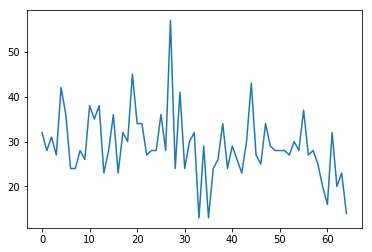

In [18]:
voluspa = MetreManager.load_poem_from_paragraphs(voluspa_paragraphs)

# for paragraph in voluspa_paragraphs:
#    if MetreManager.is_fornyrdhislag(paragraph):
#        fnl = Fornyrdhislag()
#        fnl.from_short_lines_text(paragraph)
#        voluspa.append(fnl)
#    elif MetreManager.is_ljoodhhaattr(paragraph):
#        lh = Ljoodhhaattr()
#        lh.from_short_lines_text(paragraph)
#        voluspa.append(lh)
        
number_stanzas = len(voluspa)
print("Number of stanzas:", number_stanzas)
#number_long_lines = sum([len(meter.long_lines) for meter in voluspa])
#print("Number of long lines:", number_long_lines)
number_short_lines = sum([len(meter.short_lines) for meter in voluspa])
print("Number of short lines:", number_short_lines)
number_words = sum([len(short_line.tokenized_text) for meter in voluspa for short_line in meter.short_lines])
print("Number of words:", number_words)
word_number_per_stanza = [sum([len(short_line.tokenized_text) for short_line in meter.short_lines]) for meter in voluspa ]
plt.plot(word_number_per_stanza)

Sources :
* [Heimskringla](heimskringla.no)

#### TODO
* Give distributions of syllables per short lines, long lines and stanzas.
* Give distributions of alliterations 
* Number of short lines
* Number of long lines
* Number of stanzas
* Give distribution of unigrams, bigrams
* Give the part of speech of a word
* Apply the same thing to an other eddic poem.


By Clément Besnier, email address: clemsciences@aol.com, web site: https://clementbesnier.pythonanywhere.com/, twitter: clemsciences